In [1]:
import gym
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
    The MountainCar env:
        Observation Space: there are two observables - position and velocity
        position of the car along the x-axis  in range [-1.2, 0.6]
        velocity of the car  in range [-0.07, 0.07]
'''
class Agent:
    def __init__(self, learning_rate, lr_min, gamma, epsilon, discrete_space):
        self.lr = learning_rate
        self.lr_min = lr_min
        self.epsilon = epsilon
        self.gamma = gamma
        self.act_n = 3
        self.q = np.zeros((discrete_space ** 2, self.act_n))

    def predict(self, state):
        return np.argmax(self.q[state])

    def policy(self, state):
        if np.random.uniform(0, 1) >= (1 - self.epsilon):
            action = np.random.choice(self.act_n)
        else:
            action = np.argmax(self.q[state])

        return action

    def learn(self, state, state_prime, action, action_prime, reward, done):
        predict_Q = self.q[state, action]
        if (done):
            target_Q = reward
        else:
            target_Q = reward + self.gamma * np.max(self.q[state_prime, :])

        self.q[state, action] += self.lr * (target_Q - predict_Q)

    def decay(self, epsilon_decay_rate, lr_decay_rate):
        self.epsilon *= (1 - epsilon_decay_rate)
        self.lr = max(self.lr_min, self.lr * (1 - lr_decay_rate))

In [3]:

DISCRETE = 15
def to_state(state):
    discrete_states = [
            np.linspace(-1.2, 0.6, num=(DISCRETE + 1))[1:-1],
            np.linspace(-0.07, 0.07, num=(DISCRETE + 1))[1:-1],
    ]

    state = sum(np.digitize(feature, discrete_states[i]) * (DISCRETE ** i)
                    for i, feature in enumerate(state))
    return state

def run_episode(env, agent):
    state = to_state(env.reset())
    action = agent.predict(state)
    total_reward = 0

    while True:
        state_prime, reward, done, _ = env.step(action)
        total_reward += reward

        if(done):
            break
            
        state_prime = to_state(state_prime)
        next_action = agent.policy(state_prime)
        agent.learn(state, state_prime, action, next_action, reward, done)

        state = state_prime
        action = next_action


    agent.decay(epsilon_decay_rate=5e-3, lr_decay_rate=5e-4)
    return total_reward

def main():
    env = gym.make("MountainCar-v0")

    env.seed(42)
    np.random.seed(42)

    agent = Agent(learning_rate=0.3, lr_min=1e-5, gamma=0.98, epsilon=0.9, discrete_space=DISCRETE)

    reward_list = np.zeros(10000)
    for i in range(10000):
        total_reward= run_episode(env, agent)
        reward_list[i] = total_reward

    env.env.close()

    return reward_list

reward_list = main()

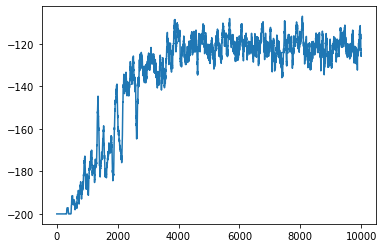

In [7]:
smoothed = []
for i in range(50):
    smoothed.append(np.mean(reward_list[:i+1]))
for i in range(50, 10000):
    smoothed.append(np.mean(reward_list[i - 50:i]))


plt.plot(range(0, 10000), smoothed)
